*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# To Boldly Go



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/track.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, underride

<IPython.core.display.Javascript object>

## Section



https://airandspace.si.edu/collection-media/NASM-A19740668000-NASM2016-02354-000005

In [1]:
filename = 'NASM-A19740668000-NASM2016-02354-000005.jpg'

In [ ]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, measure, morphology
import numpy as np

# Load and convert to grayscale
filename = 'NASM-A19740668000-NASM2016-02354-000005.jpg'
image = io.imread(filename)
gray = color.rgb2gray(image)

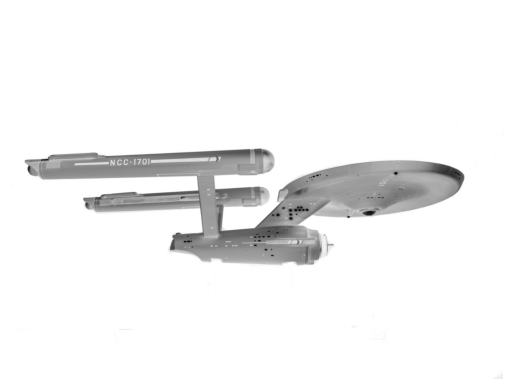

In [95]:
plt.imshow(gray, cmap='gray_r')
plt.axis('off')
None

In [142]:
smoothed = filters.gaussian(gray, sigma=5.0)  # Higher sigma = more blur

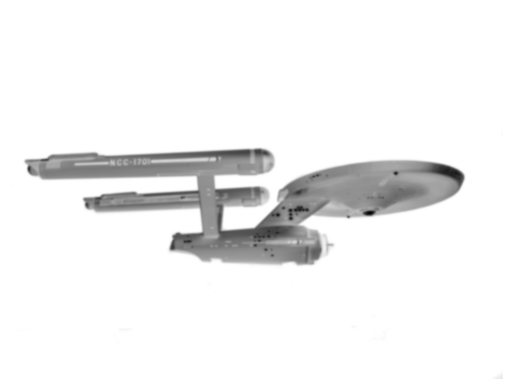

In [143]:
plt.imshow(smoothed, cmap='gray_r')
plt.axis('off')
None

In [144]:
thresh

np.float64(0.21532150029678546)

In [145]:
# Apply Otsu threshold to separate ship from black background
binary = smoothed > filters.threshold_otsu(smoothed)
binary = smoothed > 0.05

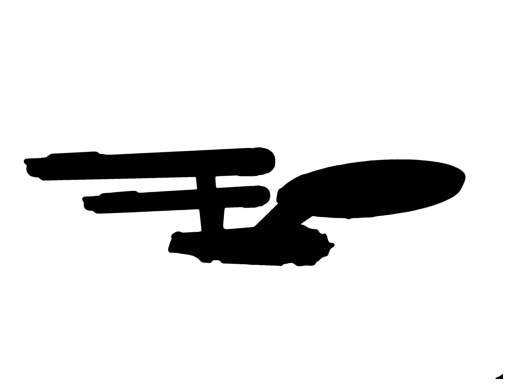

In [146]:
plt.imshow(binary, cmap='gray_r')
plt.axis('off')
None

In [147]:
# Optional: remove small artifacts
cleaned = morphology.remove_small_objects(binary, min_size=1000)

# Find contours at binary boundary (level=0.5 is midpoint between True/False)
contours = measure.find_contours(cleaned, level=0.5)
for contour in contours:
    print(contour.shape)
    break

(11559, 2)


Each point is identified by a row and column, in that order.

In [156]:
from shapely.geometry import LineString

contour = contours[0]

xy = contour[:, ::-1]
line = LineString(xy)

simplified = line.simplify(tolerance=10.0, preserve_topology=False)
contour = np.array(simplified.coords)
contour.shape

(66, 2)

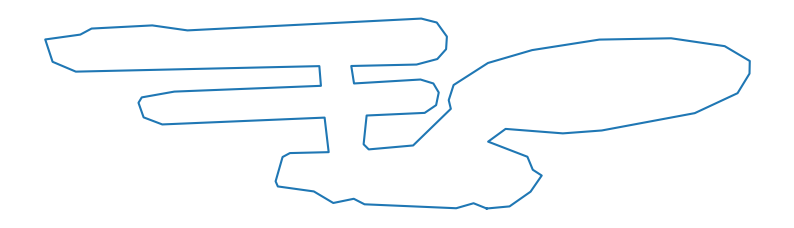

In [159]:
# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(binary, cmap='gray')

xs, ys = contour.T
ax.plot(xs, ys, linewidth=1.5)

ax.set_aspect('equal')
ax.invert_yaxis()
plt.axis('off')
None

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)